In [ ]:
import gym 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
 
# For animation 
from IPython.display import clear_output
from time import sleep
from tqdm import tqdm


In [ ]:
def boltzmann(x, temperature):
    exponent = np.true_divide(x - np.max(x), temperature)
    prob_a =  np.exp(exponent) / np.sum(np.exp(exponent))
    #cumsum_a = np.cumsum(prob_a)
    #out = np.where(np.random.rand() < cumsum_a)[0][0]
    out = np.random.choice(len(prob_a), 1, p= prob_a)
    return out[0]

def simulate_sarsa(q, T, alpha):

    done = False
    r_sum = 0
    gam = 0.9

    s = env.reset()
    a = boltzmann(q[s,:], T)

    while not done:

        # take step
        s_prime,r,done,info = env.step(a)
        a_prime = boltzmann(q[s_prime,:], T)

        q[s,a] = q[s,a] + alpha * (r + gam*q[s_prime, a_prime] - q[s,a])

        s = s_prime
        a = a_prime
        r_sum += r

    return r_sum, q

In [ ]:
def simulate_qlearning(q, T, alpha):

    done = False
    r_sum = 0
    gam = 0.9

    s = env.reset()

    while not done:

        # take step
        
        a = boltzmann(q[s,:], T)
        s_prime,r,done,info = env.step(a)

        a_prime = np.argmax(q[s_prime])
        
        q[s,a] = q[s,a] + alpha * (r + gam*q[s_prime,a_prime] - q[s,a])

        s = s_prime
        r_sum += r

    return r_sum, q

In [ ]:
def boltzmann_epd(x, temperature):
    exponent = np.true_divide(x - np.max(x), temperature)
    prob_a =  np.exp(exponent) / np.sum(np.exp(exponent))

    return prob_a
  
def testing_agent(Q):
  
  inter_rwd=[]
  state = env.reset()
  done = False
  
  while not done:
    greedy_action = np.argmax(Q[state])
    state, reward, done, info = env.step(greedy_action)
  inter_rwd.append(reward)
  
  return inter_rwd
  

def simulate_expected_sarsa(q, T, alpha):

    done = False
    r_sum = 0
    gam = 0.9

    s = env.reset()
    actionspace = range(env.action_space.n)

    while not done:

        # take step
        
        prob_a = boltzmann_epd(q[s,:], T)
        #cumsum_a = np.cumsum(prob_a)
        #a = np.where(np.random.rand() < cumsum_a)[0][0]
        a = np.random.choice(len(prob_a), 1, p= prob_a)[0]
        
        s_prime,r,done,info = env.step(a)
        
        prob_a_loop = boltzmann_epd(q[s_prime,:], T)
        
        q_a = np.sum([np.dot(p, q[s_prime,action]) for p,action in zip(prob_a_loop,actionspace)])
        q[s,a] = q[s,a] + alpha * (r + gam*q_a - q[s,a])
  
        s = s_prime
        r_sum += r

    return r_sum, q

In [ ]:
"""
One u-shaped graph that shows the effect of the parameters on the final training performance, 
expressed as the return of the agent (averaged over the last 10 training episodesand the 10 runs); 
note that this will typically end up as an upside-down u
"""

def train_model(model, env, n_squares, n_passenger_locs, n_dropoffs, T, alpha, n_episodes):

  final_rwd = []
  greedy_test_rwd = []

  for temperature in tqdm(T):
    for alp in alpha:
      test_rwd = []
      for run in range(10):
        #Independent Run
        inter_rwd = []
        avg_rwd=[]
        Q = []
        # Set up initial q-table 
        q = np.zeros(shape = (n_squares*n_passenger_locs*n_dropoffs, env.action_space.n))

        for simulate in range(100):
          r_sums = []
          for ep in range(n_episodes):
            r_sum, Q = model(q, temperature, alp)
            r_sums.append(r_sum)
        avg_rwd.append(np.mean(r_sums))
        
        #testing greegy policy from one episode:
        for _ in range(1):
          reward = testing_agent(Q)
          inter_rwd.append(reward)
        test_rwd.append(np.mean(inter_rwd))
        
      final_rwd.append((np.mean(avg_rwd), temperature, alp))
      greedy_test_rwd.append((np.mean(test_rwd), temperature, alp))
      
  return final_rwd, greedy_test_rwd


100%|██████████| 3/3 [06:06<00:00, 117.29s/it]


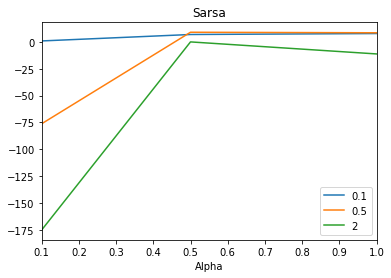

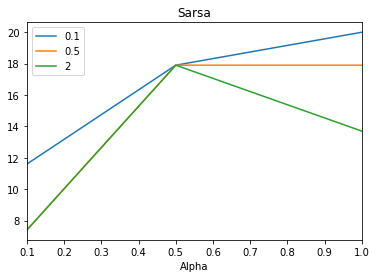

 67%|██████▋   | 2/3 [03:38<01:45, 105.53s/it]

In [ ]:
#Module to run all models
models = [simulate_sarsa, simulate_qlearning, simulate_expected_sarsa]
model_names = iter(['Sarsa','Q-learning', 'Expected Sarsa'])


env = gym.make('Taxi-v2')
n_squares = 25 
n_passenger_locs = 5
n_dropoffs = 4

T = [0.1, 0.5, 2]
alpha = [0.1, 0.5, 1]
n_episodes = 10

for model in models:
  model_name = next(model_names)
  final_rwd, greedy_test_rwd = train_model(model, env, n_squares, n_passenger_locs, n_dropoffs, T, alpha, n_episodes)
  
  #Training Plot:
  df = pd.DataFrame(final_rwd)
  df.columns = ['Avg Rewards','Temperature', 'Alpha']
  fig, ax = plt.subplots()
  for key, grp in df.groupby(['Temperature']):
    ax = grp.plot(ax=ax, kind='line', x='Alpha', y='Avg Rewards')

  plt.legend(T, loc='best')
  plt.title(model_name)
  plt.show()

  #Test Plot:
  test_df = pd.DataFrame(greedy_test_rwd)
  test_df.columns = ['Avg Rewards','Temperature', 'Alpha']
  fig, ax = plt.subplots()
  for key, grp in test_df.groupby(['Temperature']):
    ax = grp.plot(ax=ax, kind='line', x='Alpha', y='Avg Rewards')

  plt.legend(T, loc='best')
  plt.title(model_name)
  plt.show()

In [ ]:
df

,Avg Rewards,Temperature,Alpha
0,-7.720000,0.1,0.1
1,0.465000,0.1,0.5
2,2.943333,0.1,1.0
3,-14.552500,1.0,0.1
4,-10.274000,1.0,0.5
5,-7.200000,1.0,1.0
6,-32.737143,3.0,0.1
7,-32.473750,3.0,0.5
8,-31.603333,3.0,1.0


In [ ]:
""" Learning curves (mean and standard deviation computed based on the 10 runs) for what
    you pick as the best parameter setting for each algorithm """

env = gym.make('Taxi-v2')
def td_model(model):
  
  env = gym.make('Taxi-v2')
  n_squares = 25 
  n_passenger_locs = 5 
  n_dropoffs = 4

  T = [0.5]
  alpha = [1]
  n_episodes = 10

  total_reward=[]
  Q = []

  for tau in T:
    for alp in alpha:

      for run in range(10):
        avg_rwd=[]
        #Independent Run

        # Set up initial q-table 
        q = np.zeros(shape = (n_squares*n_passenger_locs*n_dropoffs, env.action_space.n))

        for simulate in range(100):
          r_sums = []

          for ep in range(n_episodes):
            r_sum, Q = model(q, tau, alp)
            r_sums.append(r_sum)

          avg_rwd.append(np.mean(r_sums))
        total_reward.append(avg_rwd)

  sarsa_mean = np.mean(total_reward, axis=0)
  sarsa_std = np.std(total_reward, axis=0)

  df_mean_std = pd.DataFrame({"Mean": sarsa_mean,
                         "Standard Deviation": sarsa_std})
  
  return df_mean_std


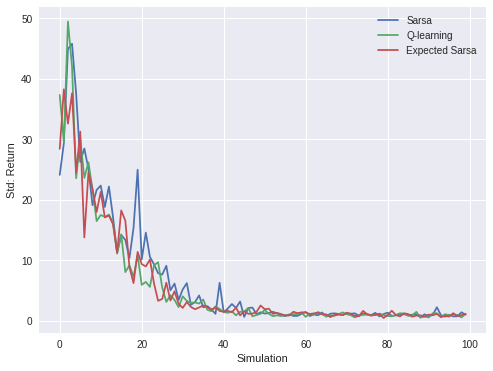

In [ ]:
models = [simulate_sarsa, simulate_qlearning, simulate_expected_sarsa]

model_names = ['Sarsa','Q-learning', 'Expected Sarsa']


for model in models:
    df_mean_std = td_model(model)
    df_mean_std['Standard Deviation'].plot(figsize = (8, 6))
    
plt.legend(model_names)
plt.xlabel('Simulation')
plt.ylabel('Std: Return')
plt.show()

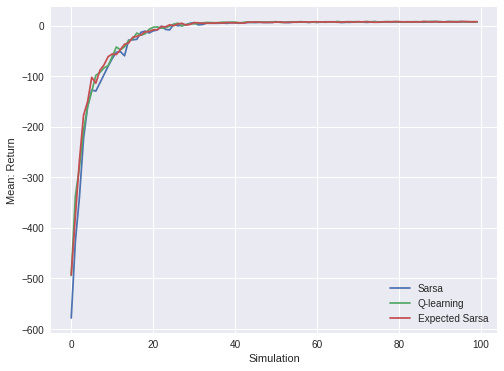

In [ ]:
models = [simulate_sarsa, simulate_qlearning, simulate_expected_sarsa]
model_names = ['Sarsa','Q-learning', 'Expected Sarsa']


for model in models:
    df_mean_std = td_model(model)
    df_mean_std['Mean'].plot(figsize = (8, 6))
    
plt.legend(model_names)
plt.xlabel('Simulation')
plt.ylabel('Mean: Return')
plt.show()